In [8]:
import sys
import numpy as np
import operator
import itertools

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

np.seterr(divide='ignore')

#def runGA():
# Generate the distributions to be used in the GP optimization process

# Index by: [sample number (0-29)]
sig_diff_samples_0v10 = np.random.normal(loc=0, scale=3, size=(30, 500))
sig_diff_samples_10v0 = np.random.normal(loc=10, scale=3, size=(30, 500))

sig_diff_samples_0v100 = np.random.normal(loc=0, scale=30, size=(30, 500))
sig_diff_samples_100v0 = np.random.normal(loc=100, scale=30, size=(30, 500))

sig_diff_samples_0v100_same_std = np.random.normal(loc=0, scale=3, size=(30, 500))
sig_diff_samples_100v0_same_std = np.random.normal(loc=100, scale=3, size=(30, 500))

sig_diff_samples_0v1000 = np.random.normal(loc=0, scale=300, size=(30, 500))
sig_diff_samples_1000v0 = np.random.normal(loc=1000, scale=300, size=(30, 500))

sig_diff_samples_0v1000_same_std = np.random.normal(loc=0, scale=3, size=(30, 500))
sig_diff_samples_1000v0_same_std = np.random.normal(loc=1000, scale=3, size=(30, 500))

# Index by: [group (0/1)][sample number (0-29)]
both_dist = np.append(sig_diff_samples_0v10[0], sig_diff_samples_10v0[0])
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v10 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v10 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

both_dist = np.append(sig_diff_samples_0v100[0], sig_diff_samples_100v0[0])
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v100 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v100 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

both_dist = np.append(sig_diff_samples_0v100_same_std[0], sig_diff_samples_100v0_same_std[0])
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v100_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v100_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

both_dist = np.append(sig_diff_samples_0v1000[0], sig_diff_samples_1000v0[0])
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v1000 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v1000 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

both_dist = np.append(sig_diff_samples_0v1000_same_std[0], sig_diff_samples_1000v0_same_std[0])
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v1000_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v1000_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

normal_dist = np.random.normal(loc=0., scale=1., size=30)
normal_dist.sort()

# GP tree: takes two arrays as input, returns a test staistic
pset = gp.PrimitiveSetTyped('MAIN', [np.ndarray, np.ndarray], float)
pset.renameArguments(ARG0='x1')
pset.renameArguments(ARG1='x2')

# Logical operators on the distance array
#pset.addPrimitive(np.logical_and, [np.ndarray, np.ndarray], np.ndarray, name='array_and')
#pset.addPrimitive(np.logical_or, [np.ndarray, np.ndarray], np.ndarray, name='array_or')
#pset.addPrimitive(np.logical_xor, [np.ndarray, np.ndarray], np.ndarray, name='array_xor')
#pset.addPrimitive(np.logical_not, [np.ndarray], np.ndarray, name='array_not')

# Mathematical operators on the distance array
pset.addPrimitive(np.add, [np.ndarray, np.ndarray], np.ndarray, name='array_add')
pset.addPrimitive(np.subtract, [np.ndarray, np.ndarray], np.ndarray, name='array_sub')
pset.addPrimitive(np.multiply, [np.ndarray, np.ndarray], np.ndarray, name='array_mul')
pset.addPrimitive(np.divide, [np.ndarray, np.ndarray], np.ndarray, name='array_div')
pset.addPrimitive(np.sqrt, [np.ndarray], np.ndarray, name='array_sqrt')
pset.addPrimitive(np.square, [np.ndarray], np.ndarray, name='array_square')
pset.addPrimitive(np.abs, [np.ndarray], np.ndarray, name='array_abs')

# Statistics derived from the distance array
pset.addPrimitive(np.mean, [np.ndarray], float, name='array_mean')
pset.addPrimitive(np.median, [np.ndarray], float, name='array_median')
pset.addPrimitive(np.min, [np.ndarray], float, name='array_min')
pset.addPrimitive(np.max, [np.ndarray], float, name='array_max')
pset.addPrimitive(np.std, [np.ndarray], float, name='array_std')
pset.addPrimitive(np.var, [np.ndarray], float, name='array_var')
pset.addPrimitive(np.size, [np.ndarray], float, name='array_size')
pset.addPrimitive(np.sum, [np.ndarray], float, name='array_sum')

# Mathematical operators with single values
def protected_div(left, right):
    try:
        return float(left) / float(right)
    except ZeroDivisionError:
        return 1.

pset.addPrimitive(operator.add, [float, float], float, name='float_add')
pset.addPrimitive(operator.sub, [float, float], float, name='float_sub')
pset.addPrimitive(operator.mul, [float, float], float, name='float_mul')
pset.addPrimitive(protected_div, [float, float], float, name='float_div')
pset.addPrimitive(np.sqrt, [float], float, name='float_sqrt')
pset.addPrimitive(np.square, [float], float, name='float_square')
pset.addPrimitive(np.abs, [float], float, name='float_abs')

# Mathematical operators on the distance array with a single value
pset.addPrimitive(np.add, [np.ndarray, float], np.ndarray, name='array_add_float')
pset.addPrimitive(np.subtract, [np.ndarray, float], np.ndarray, name='array_sub_float')
pset.addPrimitive(np.multiply, [np.ndarray, float], np.ndarray, name='array_mul_float')
pset.addPrimitive(np.divide, [np.ndarray, float], np.ndarray, name='array_div_float')

# Equivalence operators on the distance array with a single value
#pset.addPrimitive(np.less, [np.ndarray, float], np.ndarray, name='array_less_than_float')
#pset.addPrimitive(np.equal, [np.ndarray, float], np.ndarray, name='array_equal_float')

# Terminals
pset.addTerminal(1.0, float)
#pset.addEphemeralConstant('rand{}'.format(np.random.randint(1e9)), lambda: np.random.random() * 100., float)
#pset.addTerminal(np.multiply(np.random.random(size=features.shape[0]), 100.), np.ndarray)
#pset.addTerminal(np.array([True] * features.shape[0]), np.ndarray)
#pset.addTerminal(np.array([False] * features.shape[0]), np.ndarray)

creator.create('FitnessMulti', base.Fitness, weights=(1., 1., -1.))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)

"""
def return_ttest():
    return creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))', pset)

toolbox.register('individual', return_ttest)
"""
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

def evaluate_individual(individual):
    # If the solution doesn't contain both distributions, throw it out
    str_ind = str(individual)
    if 'x1' not in str_ind or 'x2' not in str_ind or '1.0' in str_ind:
        return 0., sys.maxsize, len(individual)
    
    if str_ind == 'float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))':
        print('t-test!')
    
    func = toolbox.compile(expr=individual)

    # First fitness component:
    #     - Test statistic for sig diff distributions should be high
    #     - Test statistic for non diff distributions should be low
    ts_0v10 = []
    ts_0v100 = []
    ts_0v1000 = []
    ts_0v100_same_std = []
    ts_0v1000_same_std = []
    ts_null_0v10 = []
    ts_null_0v100 = []
    ts_null_0v1000 = []
    ts_null_0v100_same_std = []
    ts_null_0v1000_same_std = []
    ts_permuted_0v10 = []
    ts_permuted_0v100 = []
    ts_permuted_0v1000 = []
    ts_permuted_0v100_same_std = []
    ts_permuted_0v1000_same_std = []
    
    # Sig diff sample comparisons
    for sample1, sample2 in zip(sig_diff_samples_0v10, sig_diff_samples_10v0):
        ts_0v10.append(func(sample1, sample2))
        ts_0v10.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v100, sig_diff_samples_100v0):
        ts_0v100.append(func(sample1, sample2))
        ts_0v100.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v1000, sig_diff_samples_1000v0):
        ts_0v1000.append(func(sample1, sample2))
        ts_0v1000.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v100_same_std, sig_diff_samples_100v0_same_std):
        ts_0v100_same_std.append(func(sample1, sample2))
        ts_0v100_same_std.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v1000_same_std, sig_diff_samples_1000v0_same_std):
        ts_0v1000_same_std.append(func(sample1, sample2))
        ts_0v1000_same_std.append(func(sample2, sample1))

    # Null sample comparisons
    for sample1, sample2 in zip(null_samples_0v10[0], null_samples_0v10[1]):
        ts_null_0v10.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(null_samples_0v100[0], null_samples_0v100[1]):
        ts_null_0v100.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(null_samples_0v1000[0], null_samples_0v1000[1]):
        ts_null_0v1000.append(func(sample1, sample2))

    for sample1, sample2 in zip(null_samples_0v100_same_std[0], null_samples_0v100_same_std[1]):
        ts_null_0v100_same_std.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(null_samples_0v1000_same_std[0], null_samples_0v1000_same_std[1]):
        ts_null_0v1000_same_std.append(func(sample1, sample2))
    
    # Permuted sample comparisons
    for sample1, sample2 in zip(permuted_samples_0v10[0], permuted_samples_0v10[1]):
        ts_permuted_0v10.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(permuted_samples_0v100[0], permuted_samples_0v100[1]):
        ts_permuted_0v100.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(permuted_samples_0v1000[0], permuted_samples_0v1000[1]):
        ts_permuted_0v1000.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(permuted_samples_0v100_same_std[0], permuted_samples_0v100_same_std[1]):
        ts_permuted_0v100_same_std.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(permuted_samples_0v1000_same_std[0], permuted_samples_0v1000_same_std[1]):
        ts_permuted_0v1000_same_std.append(func(sample1, sample2))
        
    # If the solution produces NaN values, throw it out
    if np.any(np.isnan(ts_0v10 + ts_0v100 + ts_0v1000 + ts_0v100_same_std + ts_0v1000_same_std +
                       ts_null_0v10 + ts_null_0v100 + ts_null_0v1000 +
                       ts_null_0v100_same_std + ts_null_0v1000_same_std +
                       ts_permuted_0v10 + ts_permuted_0v100 + ts_permuted_0v1000 +
                       ts_permuted_0v100_same_std + ts_permuted_0v1000_same_std)):
        return 0., sys.maxsize, len(individual)
    
    # If the solution produces inf values, throw it out
    if np.any(np.isinf(ts_0v10 + ts_0v100 + ts_0v1000 + ts_0v100_same_std + ts_0v1000_same_std +
                       ts_null_0v10 + ts_null_0v100 + ts_null_0v1000 +
                       ts_null_0v100_same_std + ts_null_0v1000_same_std +
                       ts_permuted_0v10 + ts_permuted_0v100 + ts_permuted_0v1000 +
                       ts_permuted_0v100_same_std + ts_permuted_0v1000_same_std)):
        return 0., sys.maxsize, len(individual)

    ts_ranks = []
    for (ts_sig_diff, ts_permuted) in zip([ts_0v10, ts_0v100, ts_0v1000,
                                           ts_0v100_same_std, ts_0v1000_same_std],
                                          [ts_permuted_0v10, ts_permuted_0v100, ts_permuted_0v1000,
                                           ts_permuted_0v100_same_std, ts_permuted_0v1000_same_std]):
        for ts in ts_sig_diff:
            ranked_test_statistics = list(ts_permuted)
            ranked_test_statistics.append(ts)
            ranked_test_statistics.sort()
            ts_ranks.append(abs(ranked_test_statistics.index(ts) - int(len(ranked_test_statistics) / 2.)))

    for (ts_null, ts_permuted) in zip([ts_null_0v10, ts_null_0v100, ts_null_0v1000,
                                       ts_null_0v100_same_std, ts_null_0v1000_same_std],
                                      [ts_permuted_0v10, ts_permuted_0v100, ts_permuted_0v1000,
                                       ts_permuted_0v100_same_std, ts_permuted_0v1000_same_std]):
        for ts in ts_null:
            ranked_test_statistics = list(ts_permuted)
            ranked_test_statistics.append(ts)
            ranked_test_statistics.sort()
            mid_index = int(len(ranked_test_statistics) / 2.)
            mid_dist = mid_index - abs(mid_index - ranked_test_statistics.index(ts))
            #if mid_dist >= 2:
            #    mid_dist = 15
            ts_ranks.append(mid_dist)

    # Second fitness component: Test statistic should be scale invariant
    test_stats_variance = 0.
    for null_dist in [ts_null_0v10, ts_null_0v100, ts_null_0v1000,
                      ts_null_0v100_same_std, ts_null_0v1000_same_std]:
        null_dist = list(null_dist)
        null_dist.sort()
        test_stats_variance += np.sqrt(np.sum(np.square(np.subtract(null_dist, normal_dist))))
    #test_stats_variance /= 5.

    # Third fitness component is the size (i.e., complexity) of the GP tree
    ind_complexity = np.sum([type(component) == gp.Primitive and 'array' in component.name for component in individual])
    
    return (
        round(sum(ts_ranks) / (len(ts_ranks) * 15.), 2),
        round(1. / test_stats_variance, 2),
        ind_complexity
           )

toolbox.register('evaluate', evaluate_individual)
toolbox.register('select', tools.selNSGA2)
toolbox.register('mate', gp.cxOnePoint)
toolbox.register('expr_mut', gp.genFull, min_=0, max_=2)
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

def pareto_eq(ind1, ind2):
    """Determines whether two individuals are equal on the Pareto front
    Parameters
    ----------
    ind1: DEAP individual from the GP population
        First individual to compare
    ind2: DEAP individual from the GP population
        Second individual to compare
    Returns
    ----------
    individuals_equal: bool
        Boolean indicating whether the two individuals are equal on
        the Pareto front
    """
    return np.allclose(ind1.fitness.values, ind2.fitness.values)

pop = toolbox.population(n=500)
pareto_front = tools.ParetoFront(similar=pareto_eq)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register('avg', np.mean)
stats.register('std', np.std)
stats.register('min', np.min)
stats.register('max', np.max)

t_test = creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))', pset)
print('t-test fitness: {}'.format(evaluate_individual(t_test)))

algorithms.eaMuPlusLambda(population=pop, toolbox=toolbox,
                          cxpb=0.5, mutpb=0.5, mu=500, lambda_=500,
                          ngen=100, stats=stats, halloffame=pareto_front)

print('')
for index, ind in enumerate(pareto_front):
    print(index, ind.fitness, ind)

t-test!
t-test fitness: (0.84, 0.080000000000000002, 6)


<string>:1: RuntimeWarning: invalid value encountered in sqrt


gen	nevals	avg    	std     	min	max 
0  	500   	0.07222	0.221838	0  	0.85
1  	1000  	0.01838	0.122594	0  	0.86
2  	1000  	0.01674	0.117231	0  	0.86


/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


3  	1000  	0.03528	0.168536	0  	0.86
4  	1000  	0.03198	0.16098 	0  	0.86
5  	1000  	0.01532	0.113166	0  	0.86
6  	1000  	0.01352	0.106036	0  	0.86
7  	1000  	0.01012	0.0918389	0  	0.86
8  	1000  	0.01858	0.123897 	0  	0.86
9  	1000  	0.01016	0.0921996	0  	0.86
10 	1000  	0.0221 	0.135278 	0  	0.86
11 	1000  	0.01532	0.113168 	0  	0.86
12 	1000  	0.0289 	0.154053 	0  	0.86
13 	1000  	0.04592	0.192205 	0  	0.86
14 	1000  	0.09526	0.26824  	0  	0.86
15 	1000  	0.0136 	0.106665 	0  	0.86
16 	1000  	0.0239 	0.140827 	0  	0.86
17 	1000  	0.03588	0.17137  	0  	0.86
18 	1000  	0.03748	0.174712 	0  	0.86
19 	1000  	0.07676	0.24409  	0  	0.86


/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:101: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


20 	1000  	0.05832	0.215918 	0  	0.86
21 	1000  	0.0153 	0.113019 	0  	0.86
22 	1000  	0.0272 	0.149616 	0  	0.86
23 	1000  	0.05774	0.213786 	0  	0.86
24 	1000  	0.0442 	0.188729 	0  	0.86
25 	1000  	0.02048	0.130613 	0  	0.86
26 	1000  	0.03418	0.167461 	0  	0.86
27 	1000  	0.08882	0.260725 	0  	0.86
28 	1000  	0.22522	0.37609  	0  	0.86
29 	1000  	0.42476	0.426532 	0  	0.86
30 	1000  	0.0136 	0.106665 	0  	0.86
31 	1000  	0.02384	0.140472 	0  	0.86
32 	1000  	0.04422	0.188822 	0  	0.86
33 	1000  	0.0784 	0.246308 	0  	0.86
34 	1000  	0.02564	0.145806 	0  	0.86
35 	1000  	0.01532	0.113168 	0  	0.86
36 	1000  	0.0307 	0.158878 	0  	0.86
37 	1000  	0.06824	0.231432 	0  	0.86
38 	1000  	0.05316	0.20678  	0  	0.86
39 	1000  	0.0136 	0.106665 	0  	0.86
40 	1000  	0.02042	0.130234 	0  	0.86
41 	1000  	0.02902	0.154695 	0  	0.86
42 	1000  	0.06494	0.226446 	0  	0.86
43 	1000  	0.14548	0.321467 	0  	0.86
44 	1000  	0.0918 	0.263828 	0  	0.86
45 	1000  	0.18358	0.349757 	0  	0.86
46 	1000  	0

float_div(array_mean(x1), array_max(x2))



''

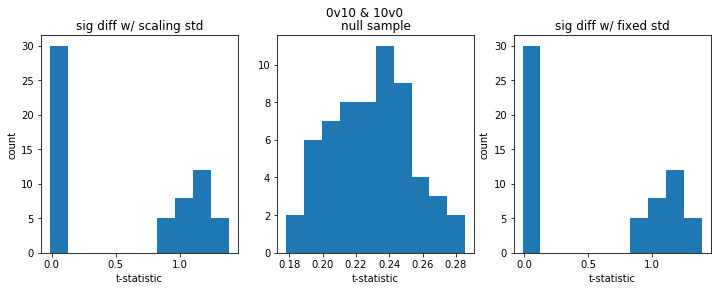

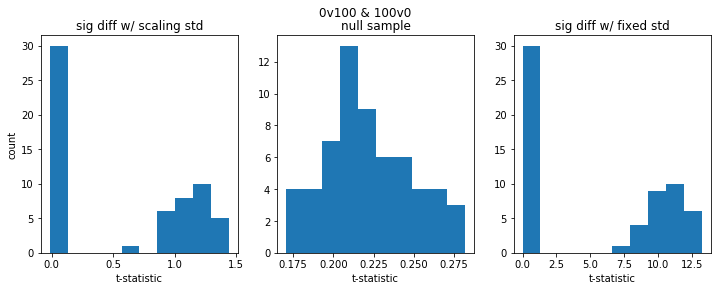

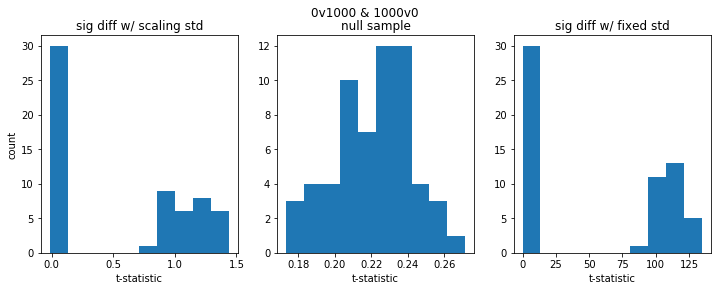

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

pareto_index = 0

print(pareto_front[pareto_index])
print('')
func = toolbox.compile(expr=pareto_front[pareto_index])

### 0v10 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v10 & 10v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v10, sig_diff_samples_10v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('sig diff w/ scaling std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ scaling std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v10[0], null_samples_0v10[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.subplot(1, 3, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v10, sig_diff_samples_10v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('sig diff w/ fixed std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ fixed std')

### 0v100 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v100 & 100v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v100, sig_diff_samples_100v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('sig diff w/ scaling std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ scaling std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v100[0], null_samples_0v100[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v100_same_std, sig_diff_samples_100v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('sig diff w/ fixed std')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='sig diff w/ fixed std')

### 0v1000 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v1000 & 1000v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v1000, sig_diff_samples_1000v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('sig diff w/ scaling std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ scaling std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v1000[0], null_samples_0v1000[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v1000_same_std, sig_diff_samples_1000v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('sig diff w/ fixed std')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='sig diff w/ fixed std')
;

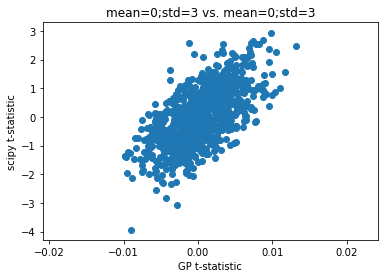

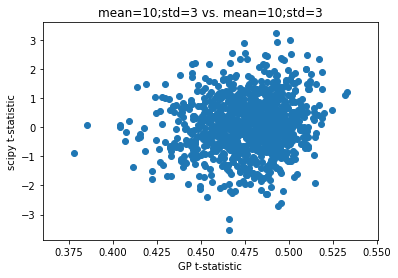

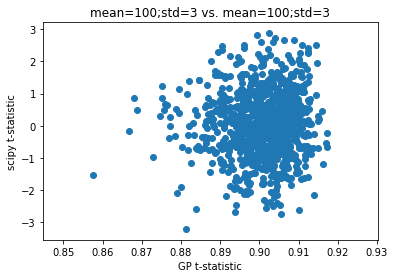

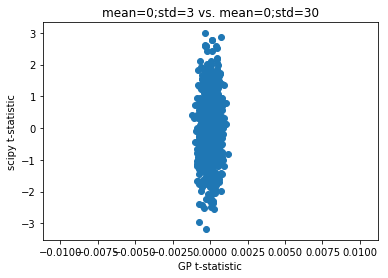

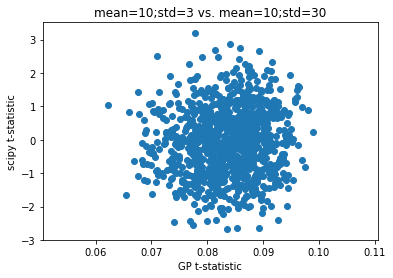

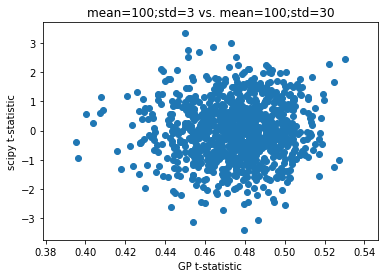

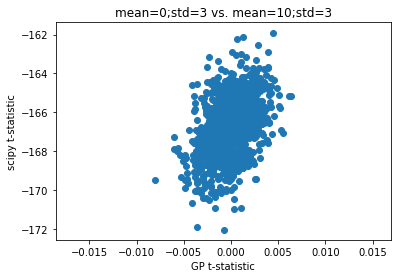

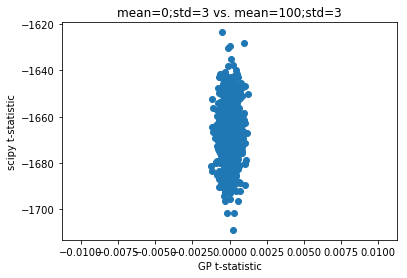

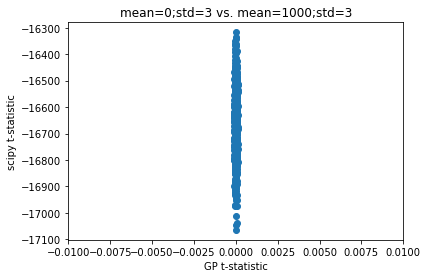

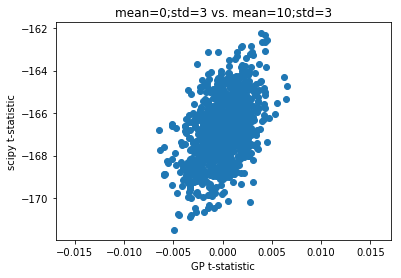

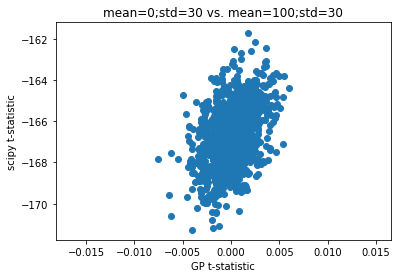

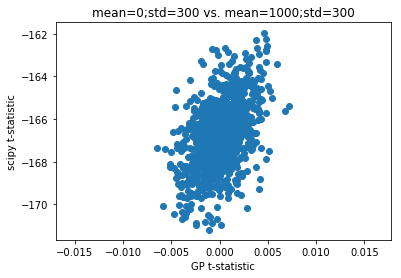

In [7]:
def plot_test_dist(stat_func, loc1, loc2, std1=3, std2=3):
    stat_dist = []
    ttest_dist = []
    for rep in range(1000):
        dist1 = np.random.normal(loc=loc1, scale=std1, size=5000)
        dist2 = np.random.normal(loc=loc2, scale=std2, size=5000)
        stat_dist.append(stat_func(dist1, dist2))
        ttest_dist.append(ttest_ind(dist1, dist2).statistic)
    plt.figure()
    plt.title('mean={};std={} vs. mean={};std={}'.format(loc1, std1, loc2, std2))
    plt.scatter(stat_dist, ttest_dist)
    plt.xlabel('GP t-statistic')
    plt.ylabel('scipy t-statistic')

# Same mean, same std
plot_test_dist(func, 0, 0)
plot_test_dist(func, 10, 10)
plot_test_dist(func, 100, 100)

# Same mean, diff std
plot_test_dist(func, 0, 0, std1=3, std2=30)
plot_test_dist(func, 10, 10, std1=3, std2=30)
plot_test_dist(func, 100, 100, std1=3, std2=30)

# Diff mean, same std
plot_test_dist(func, 0, 10)
plot_test_dist(func, 0, 100)
plot_test_dist(func, 0, 1000)

# Diff mean, diff std
plot_test_dist(func, 0, 10)
plot_test_dist(func, 0, 100, std1=30, std2=30)
plot_test_dist(func, 0, 1000, std1=300, std2=300)